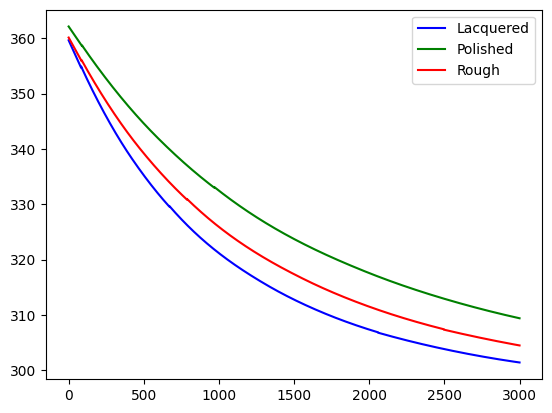

In [175]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

sigma = 5.670374419E-8

emmL = 0.7
emmP = 0.03
emmR = 0.4

rhoAl = 2710
hcAl = 897
Tamb = 22.2 + 273.15

radL = 12.55E-3
radP = 12.95E-3
radR = 12.95E-3

lengthL = 282E-3
lengthP = 305E-3
lengthR = 304.5E-3

hlengthL = 82.1E-3
hlengthP = 80.1E-3
hlengthR = 80.5E-3

hrad = 3.4E-3

volL = np.pi * radL ** 2 * lengthL - np.pi * hrad ** 2 * hlengthL
volP = np.pi * radP ** 2 * lengthP - np.pi * hrad ** 2 * hlengthR
volR = np.pi * radR ** 2 * lengthR - np.pi * hrad ** 2 * hlengthR

holeA = 3.5E-3 ** 2 * np.pi

saL = 2 * radL * np.pi * lengthL - holeA + radL ** 2 * np.pi
saP = 2 * radP * np.pi * lengthP - holeA + radP ** 2 * np.pi
saR = 2 * radR * np.pi * lengthR - holeA + radR ** 2 * np.pi

massL = rhoAl * volL
massP = rhoAl * volP
massR = rhoAl * volR

TiL = 359.65
TiP = 362.15
TiR = 360.15

y_0L = [TiL]
carrL = [massL, emmL, saL, radL]
y_0P = [TiP]
carrP = [massP, emmP, saP, radP]
y_0R = [TiR]
carrR = [massR, emmR, saR, radR]

y_0arr = [y_0L, y_0P, y_0R]
carrAll = [carrL, carrP, carrR]


def h(T, T_0, r):
    return ((T - T_0) / (2 * r)) ** (1/4)


def dydt_arr(t, y_arr, M, e, A, r):
    """Relates the used physical quantities to their differential
    equations for use in the scipy numerical integration function"""

    T = y_arr[0]

    # dT/dt
    return np.array([(-A * e * sigma * T ** 4 - 1.32 * h(T, Tamb, r) * A * (T - Tamb) + A * e * sigma * Tamb ** 4) / (M * hcAl)])

t_0 = 0
t_f = 3000
steps = int(1E5)
t_arr = np.linspace(t_0, t_f, steps)

solarr = []

for i in range(3):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                                y_0arr[i],
                                method='LSODA',
                                t_eval=t_arr, 
                                args=carrAll[i])
    
    solT = sol['y'][0]
    solarr.append(solT)

plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Lacquered', 'Polished', 'Rough'])
plt.show()

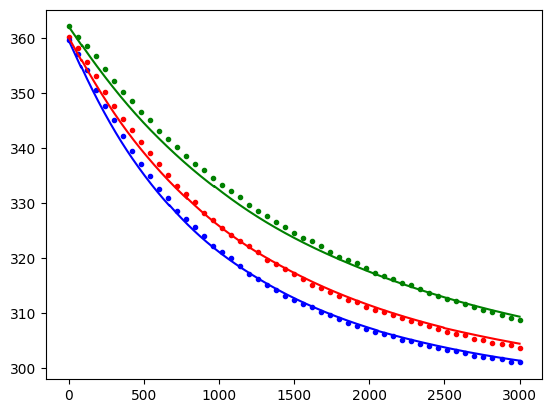

In [176]:
fname = 'experimentdata.csv'
colours = ["r.", "g.", "b."]

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

x = data[:, 0]
plt.plot(x, data[:, 1], colours[0], x, data[:, 2],
         colours[1], x, data[:, 3], colours[2])

plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")


Lacquered Chi-Square:  3.5943016823372917
Polished Chi-Square:  7.726857311055133
Rough Chi-Square:  3.6826886872813582


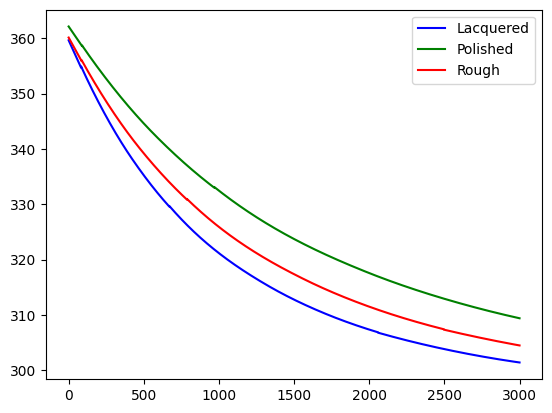

In [177]:
t_0 = 0
t_f = 3000
steps = int(t_f*1E2)
t_arr = np.linspace(t_0, t_f, steps)

steps_per_data = int(3*20 * steps / t_f)


def chi_square(data, model, sigma=2.5):
    return np.sum((model-data)**2/sigma**2)

solarr = []

def model_function(i):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)


fname = 'experimentdata.csv'

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

for i in range(3):
    model_function(i)


print("Lacquered Chi-Square: ", chi_square(data[:-1, 3], solarr[0][::steps_per_data]))
print("Polished Chi-Square: ",
      chi_square(data[:-1, 2], solarr[1][::steps_per_data]))
print("Rough Chi-Square: ",
      chi_square(data[:-1, 1], solarr[2][::steps_per_data]))


plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Lacquered', 'Polished', 'Rough'])
plt.show()

In [178]:
count = 0
i = 0

names = ["Lacquered", "Polished", "Rough"]
carrL = [massL, emmL, saL, radL]
carrP = [massP, emmP, saP, radP]
carrR = [massR, emmR, saR, radR]

carrAll = [carrL, carrP, carrR]
emissivities = []
chis = []

def get_chi(e):
    # global i

    carrAll[i][1] = e

    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]

    return chi_square(data[:-1,3-i], solT[::steps_per_data])

num_emissivities = 5

def find_e(e_range=np.linspace(1E-9, 1, num_emissivities)):
    global count

    chis = list(map(get_chi, e_range))
    minarg = np.argmin(chis)
    minchi = min(chis)
    # print("Count: ", count)
    # print("minchi: ", minchi)
    # print("minarg: ", minarg)
    # if i == 1:
    #     print("minchi: ", minchi)
    #     print("min e: ", e_range[minarg])
    #     print(e_range)

    if minchi < 1 or count > 20:
        return e_range[minarg], minchi
    
    count += 1

    if minarg == num_emissivities-1:

        return find_e(np.linspace(e_range[minarg-1], e_range[minarg]+(max(e_range)-min(e_range))/num_emissivities, num_emissivities))
    
    if minarg == 0:
        min_e = e_range[minarg]-(max(e_range)+min(e_range))/num_emissivities
        if min_e < 0:
            min_e = 1E-7

        return find_e(np.linspace(min_e, e_range[minarg+1], num_emissivities))

    return find_e(np.linspace(e_range[minarg-1], e_range[minarg+1], num_emissivities))

for x in range(3):
    count = 0
    i = x
    results = find_e()
    emissivities.append(results[0])
    chis.append(results[1])
    print(names[i])
    print("emissivity found:", results[0])
    print("chi-square:", results[1])
    print()

    
    

Lacquered
emissivity found: 0.687528729751253
chi-square: 3.485068949856116

Polished
emissivity found: 5.984609146677744e-08
chi-square: 4.506764870773422

Rough
emissivity found: 0.4028204685460931
chi-square: 3.6740880318099243



[0.4275476052805369, 5.984609146677744e-08, 0.025305379599014733, 0.01295]
Lacquered Chi-Square:  3.485068949856116
Polished Chi-Square:  4.506764870773422
Rough Chi-Square:  3.6740880318099243


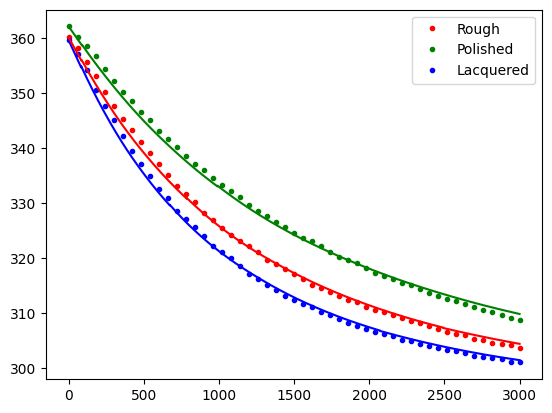

In [179]:
carrAll[0][1] = emissivities[0]
carrAll[1][1] = emissivities[1]
carrAll[2][1] = emissivities[2]
print(carrAll[:][1])

solarr = []

for i in range(3):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)


print("Lacquered Chi-Square: ",
      chis[0])
print("Polished Chi-Square: ",
      chis[1])
print("Rough Chi-Square: ",
      chis[2])
      
x = data[:, 0]
plt.plot(x, data[:, 1], colours[0], x, data[:, 2],
         colours[1], x, data[:, 3], colours[2])

plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Rough', 'Polished', 'Lacquered'])
plt.show()
